<a href="https://colab.research.google.com/github/Aamna-Khan-Git/Models/blob/main/Brain_Tumor_MRI_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries

In [1]:
import os
import PIL
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from PIL import Image
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.applications import (
    ResNet50, MobileNetV2, InceptionV3, EfficientNetB0,
    VGG16, DenseNet121, Xception )
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model

# Mounting drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Storing paths to train, test and validation datasets

In [3]:
train_data = r'/content/drive/MyDrive/Colab Notebooks/labmentix/Tumour/train'
test_data = r'/content/drive/MyDrive/Colab Notebooks/labmentix/Tumour/test'
val_data = r'/content/drive/MyDrive/Colab Notebooks/labmentix/Tumour/valid'

# ***1. UNDERSTAND THE DATA***

# Reviewing number of categories

In [4]:
#printing the labels from training data
labels = os.listdir(train_data)
print(labels)
labels = labels[1:]
print("Labels for analysis:",labels)

# Displaying the number of images in each directory
for label in labels:
    label_dir = os.path.join(train_data, label)
    try:
        images = os.listdir(label_dir)
        image_count = 0
        for image in images:
            if image.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_count += 1
        print(f"Number of images in '{label}': {image_count}")
    except FileNotFoundError:
        print(f"Directory not found for label: {label}")
    except Exception as e:
        print(f"An error occurred for label {label}: {e}")

['_classes.csv', 'no_tumor', 'meningioma', 'pituitary', 'glioma']
Labels for analysis: ['no_tumor', 'meningioma', 'pituitary', 'glioma']
Number of images in 'no_tumor': 340
Number of images in 'meningioma': 363
Number of images in 'pituitary': 443
Number of images in 'glioma': 569


# Reviewing sample images from each category

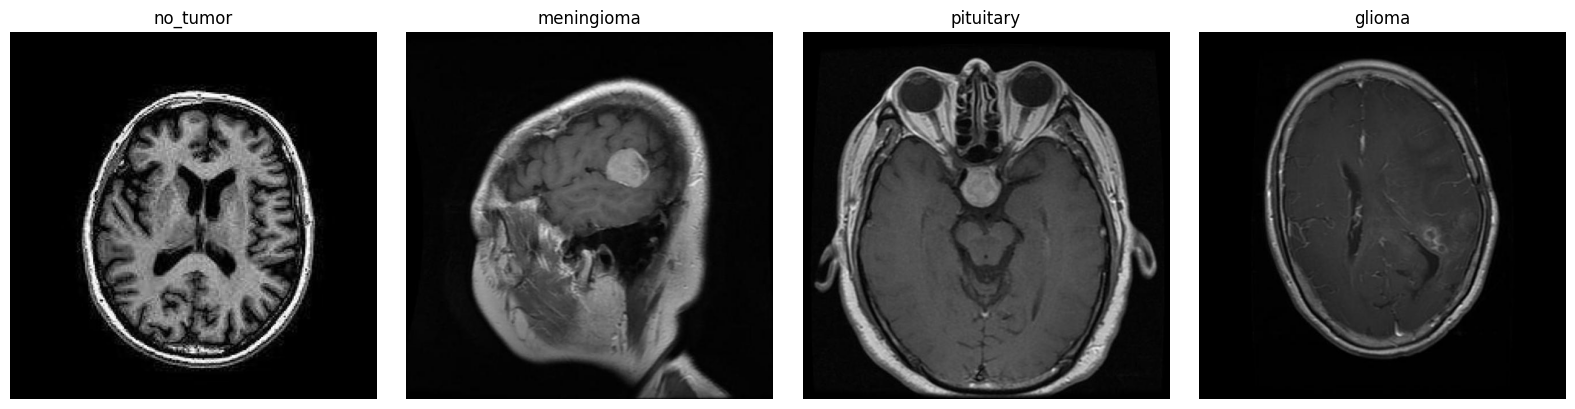

In [5]:

num_labels = len(labels)
fig, axes = plt.subplots(1, num_labels, figsize=(num_labels * 4, 4)) # Create subplots

for i, label in enumerate(labels):
    label_dir = os.path.join(train_data, label)
    try:
        images = os.listdir(label_dir)

        # Find the first image file (assuming image files end with .jpg, .jpeg, or .png)
        image_file = None
        for image in images:
            if image.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_file = os.path.join(label_dir, image)
                break

        if image_file:
            img = mpimg.imread(image_file)
            axes[i].imshow(img) # Display image in the i-th subplot
            axes[i].set_title(label) # Set title for the i-th subplot
            axes[i].axis('off') # Turn off axis for the i-th subplot
        else:
            print(f"No image found for label: {label}")
            axes[i].set_title(f"{label} (No Image)") # Indicate no image found
            axes[i].axis('off')
    except FileNotFoundError:
        print(f"Directory not found for label: {label}")
        axes[i].set_title(f"{label} (Dir Not Found)") # Indicate directory not found
        axes[i].axis('off')
    except Exception as e:
        print(f"An error occurred for label {label}: {e}")
        axes[i].set_title(f"{label} (Error)") # Indicate error
        axes[i].axis('off')

plt.tight_layout() # Adjust layout to prevent overlap
plt.show()

# Checking for image resolution of an image in each class

In [6]:
from PIL import Image

for label in labels:
    label_dir = os.path.join(train_data, label)
    try:
        images = os.listdir(label_dir)
        image_file = None
        for image in images:
            if image.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_file = os.path.join(label_dir, image)
                break

        if image_file:
            with Image.open(image_file) as img:
                width, height = img.size
                print(f"Resolution of an image in '{label}': {width}x{height}")
        else:
            print(f"No image found for label: {label}")
    except FileNotFoundError:
        print(f"Directory not found for label: {label}")
    except Exception as e:
        print(f"An error occurred for label {label}: {e}")

Resolution of an image in 'no_tumor': 640x640
Resolution of an image in 'meningioma': 640x640
Resolution of an image in 'pituitary': 640x640
Resolution of an image in 'glioma': 640x640


# Exploring image distribution and class imbalance visually

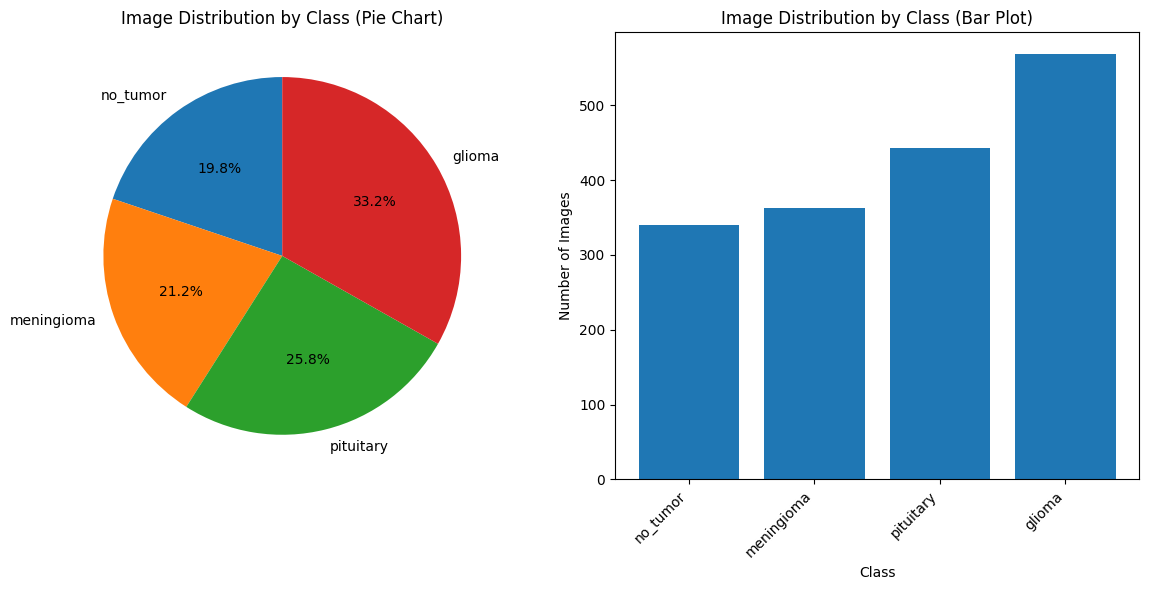

In [7]:
# Assuming 'labels' and 'image_count' (calculated in the previous cell) are available
# Create a dictionary of labels and their corresponding image counts
image_counts = {}
for label in labels:
    label_dir = os.path.join(train_data, label)
    try:
        images = os.listdir(label_dir)
        count = 0
        for image in images:
            if image.lower().endswith(('.jpg', '.jpeg', '.png')):
                count += 1
        image_counts[label] = count
    except FileNotFoundError:
        print(f"Directory not found for label: {label}")
        image_counts[label] = 0 # Assign 0 if directory not found
    except Exception as e:
        print(f"An error occurred for label {label}: {e}")
        image_counts[label] = 0 # Assign 0 in case of other errors

labels_list = list(image_counts.keys())
counts_list = list(image_counts.values())

# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Pie chart
axes[0].pie(counts_list, labels=labels_list, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Image Distribution by Class (Pie Chart)')

# Bar plot
axes[1].bar(labels_list, counts_list)
axes[1].set_title('Image Distribution by Class (Bar Plot)')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Number of Images')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability

plt.tight_layout() # Adjust layout to prevent overlap
plt.show()

# ***2. DATA PREPROCESSING***

# Normalising and resizing training images

In [8]:
from PIL import Image

def load_and_normalize_images(train_data, target_size=(224, 224)):
    """Loads and resizes images from a directory, normalizes pixel values, and returns images and labels."""
    images = []
    labels = []
    for label in os.listdir(train_data):
        label_dir = os.path.join(train_data, label)
        if os.path.isdir(label_dir):
            for image_name in os.listdir(label_dir):
                if image_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_path = os.path.join(label_dir, image_name)
                    try:
                        with Image.open(image_path) as img:
                            # Convert image to RGB if it's not (to handle grayscale etc.)
                            img = img.convert('RGB')

                            # Resize image
                            img_resized = img.resize(target_size)

                            img_array = np.array(img_resized)

                            # Normalize pixel values to 0-1 scale
                            normalized_img_array = img_array / 255.0

                            images.append(normalized_img_array)
                            labels.append(label)
                    except Exception as e:
                        print(f"Could not load, resize, or process image {image_path}: {e}")
    return np.array(images), np.array(labels)

# Normalising and resizing testing images

In [9]:
from PIL import Image

def load_and_normalize_images(test_data, target_size=(224, 224)):
    """Loads images from a directory, normalizes pixel values, and returns images and labels."""
    images = []
    labels = []
    for label in os.listdir(test_data):
        label_dir = os.path.join(test_data, label)
        if os.path.isdir(label_dir):
            for image_name in os.listdir(label_dir):
                if image_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_path = os.path.join(label_dir, image_name)
                    try:
                        with Image.open(image_path) as img:
                            # Convert image to RGB if it's not (to handle grayscale etc.)
                            img = img.convert('RGB')
                            img_array = np.array(img)

                             # Resize image
                            img_resized = img.resize(target_size)

                            img_array = np.array(img_resized)

                            # Normalize pixel values to 0-1 scale
                            normalized_img_array = img_array / 255.0

                            images.append(normalized_img_array)
                            labels.append(label)
                    except Exception as e:
                        print(f"Could not load or process image {image_path}: {e}")
    return np.array(images), np.array(labels)

# Normalising and resizing validation images

In [10]:
from PIL import Image

def load_and_normalize_images(val_data, target_size=(224, 224)):
    """Loads images from a directory, normalizes pixel values, and returns images and labels."""
    images = []
    labels = []
    for label in os.listdir(val_data):
        label_dir = os.path.join(val_data, label)
        if os.path.isdir(label_dir):
            for image_name in os.listdir(label_dir):
                if image_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_path = os.path.join(label_dir, image_name)
                    try:
                        with Image.open(image_path) as img:
                            # Convert image to RGB if it's not (to handle grayscale etc.)
                            img = img.convert('RGB')
                            img_array = np.array(img)

                             # Resize image
                            img_resized = img.resize(target_size)

                            img_array = np.array(img_resized)

                            # Normalize pixel values to 0-1 scale
                            normalized_img_array = img_array / 255.0

                            images.append(normalized_img_array)
                            labels.append(label)
                    except Exception as e:
                        print(f"Could not load or process image {image_path}: {e}")
    return np.array(images), np.array(labels)

# ***3. DATA AUGMENTATION***

# Augmenting an image from glioma directory

=== Single Brain MRI Image Augmentation ===
Processing image: Tr-gl_0011_jpg.rf.61e213cb5a0f97fedd1bacd0428c0133.jpg
Creating 5 augmented versions...


/tmp/ipython-input-11-2225417689.py:62: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  pil_img = Image.fromarray(augmented_img, mode='L')


  Saved: aug_Tr-gl_0011_jpg.rf.61e213cb5a0f97fedd1bacd0428c0133_01.jpg
  Saved: aug_Tr-gl_0011_jpg.rf.61e213cb5a0f97fedd1bacd0428c0133_02.jpg
  Saved: aug_Tr-gl_0011_jpg.rf.61e213cb5a0f97fedd1bacd0428c0133_03.jpg
  Saved: aug_Tr-gl_0011_jpg.rf.61e213cb5a0f97fedd1bacd0428c0133_04.jpg
  Saved: aug_Tr-gl_0011_jpg.rf.61e213cb5a0f97fedd1bacd0428c0133_05.jpg

Augmentation complete!
Generated 5 augmented images
Saved in directory: /content/drive/MyDrive/Colab Notebooks/labmentix/Tumour/train/glioma

Displaying results...
Displaying original + 5 augmented versions


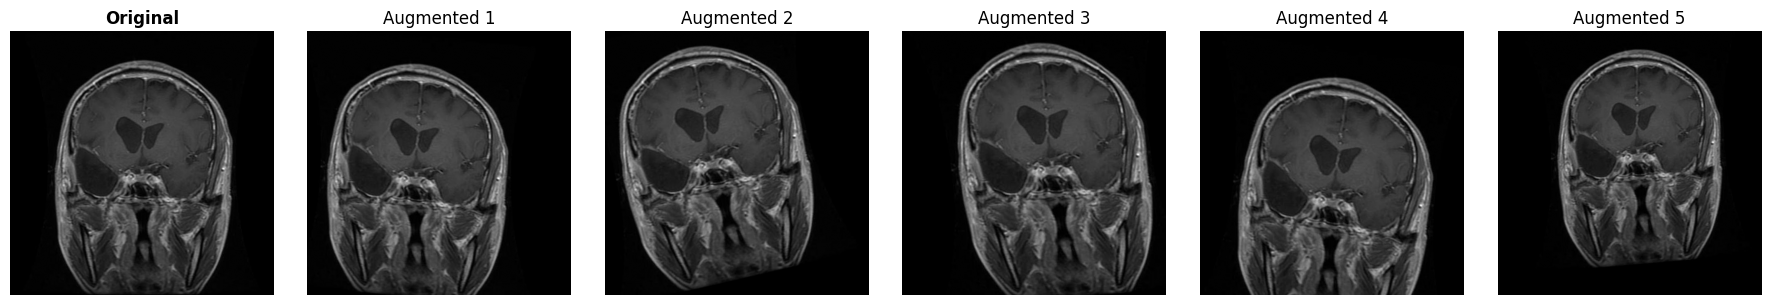

In [11]:
def augment_single_brain_mri(image_path, num_augmentations=5):
    """
    Augment a single brain MRI image and save augmented versions to the same directory.

    Args:
        image_path (str): Full path to the single MRI image
        num_augmentations (int): Number of augmented versions to create
    """

    # Brain MRI specific augmentation configuration
    datagen = ImageDataGenerator(
        rotation_range=15,           # Small rotations (brain orientation matters)
        width_shift_range=0.1,       # Horizontal shifts
        height_shift_range=0.1,      # Vertical shifts
        zoom_range=0.1,              # Slight zoom variations
        shear_range=5,               # Small shear transformations
        brightness_range=[0.8, 1.2], # Brightness variations
        horizontal_flip=False,       # No horizontal flip (brain asymmetry is important)
        vertical_flip=False,         # No vertical flip
        fill_mode='constant',        # Fill with constant value (black)
        cval=0.0,                    # Fill value (black for medical images)
        rescale=None                 # Don't rescale - keep original pixel values
    )

    # Check if image exists
    if not os.path.exists(image_path):
        print(f"Error: Image '{image_path}' does not exist!")
        return

    # Get directory and filename info
    directory = os.path.dirname(image_path)
    filename = os.path.basename(image_path)
    base_name = os.path.splitext(filename)[0]
    extension = os.path.splitext(filename)[1]

    print(f"Processing image: {filename}")
    print(f"Creating {num_augmentations} augmented versions...")

    try:
        # Load and preprocess image
        img = load_img(image_path, color_mode='grayscale')  # Load as grayscale for MRI
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)

        # Keep original range (0-255) - don't normalize for augmentation
        # The ImageDataGenerator works fine with 0-255 range

        # Generate augmented images
        i = 0
        for batch in datagen.flow(x, batch_size=1):
            # Get the augmented image (already in 0-255 range)
            augmented_img = batch[0].astype(np.uint8)

            # Save augmented image
            aug_filename = f"aug_{base_name}_{i+1:02d}{extension}"
            aug_path = os.path.join(directory, aug_filename)

            # Convert array back to PIL Image and save
            if len(augmented_img.shape) == 3 and augmented_img.shape[2] == 1:
                augmented_img = augmented_img.squeeze()

            pil_img = Image.fromarray(augmented_img, mode='L')
            pil_img.save(aug_path)

            print(f"  Saved: {aug_filename}")

            i += 1
            if i >= num_augmentations:
                break

        print(f"\nAugmentation complete!")
        print(f"Generated {num_augmentations} augmented images")
        print(f"Saved in directory: {directory}")

    except Exception as e:
        print(f"Error processing image: {str(e)}")


def display_original_and_augmented(image_path):
    """
    Display the original image alongside its augmented versions.

    Args:
        image_path (str): Path to the original image
    """

    if not os.path.exists(image_path):
        print(f"Error: Image '{image_path}' does not exist!")
        return

    # Get directory and filename info
    directory = os.path.dirname(image_path)
    filename = os.path.basename(image_path)
    base_name = os.path.splitext(filename)[0]
    extension = os.path.splitext(filename)[1]

    # Find corresponding augmented images
    augmented_files = []
    for f in os.listdir(directory):
        if f.startswith(f'aug_{base_name}_') and f.endswith(extension):
            augmented_files.append(f)

    # Sort augmented files for consistent display
    augmented_files.sort()

    if not augmented_files:
        print("No augmented images found! Run augmentation first.")
        return

    print(f"Displaying original + {len(augmented_files)} augmented versions")

    # Load original image
    original_img = load_img(image_path, color_mode='grayscale')

    # Create subplot layout
    num_total = len(augmented_files) + 1  # +1 for original
    cols = min(6, num_total)  # Max 6 columns
    rows = (num_total + cols - 1) // cols  # Calculate needed rows

    fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))

    # Handle single row case
    if rows == 1:
        if cols == 1:
            axes = [axes]
        else:
            axes = axes.reshape(1, -1)

    # Flatten axes for easier indexing
    axes_flat = axes.flatten() if num_total > 1 else [axes]

    # Display original image
    axes_flat[0].imshow(original_img, cmap='gray')
    axes_flat[0].set_title('Original', fontsize=12, fontweight='bold')
    axes_flat[0].axis('off')

    # Display augmented images
    for i, aug_file in enumerate(augmented_files):
        aug_path = os.path.join(directory, aug_file)
        aug_img = load_img(aug_path, color_mode='grayscale')

        axes_flat[i + 1].imshow(aug_img, cmap='gray')
        axes_flat[i + 1].set_title(f'Augmented {i + 1}', fontsize=12)
        axes_flat[i + 1].axis('off')

    # Hide unused subplots
    for i in range(num_total, len(axes_flat)):
        axes_flat[i].axis('off')

    plt.tight_layout()
    plt.show()


# Example usage:
if __name__ == "__main__":
    # Set your image path here
    image_path = "/content/drive/MyDrive/Colab Notebooks/labmentix/Tumour/train/glioma/Tr-gl_0011_jpg.rf.61e213cb5a0f97fedd1bacd0428c0133.jpg"  # UPDATE THIS PATH

    print("=== Single Brain MRI Image Augmentation ===")

    # Step 1: Augment the single image
    augment_single_brain_mri(image_path, num_augmentations=5)

    # Step 2: Display results
    print("\nDisplaying results...")
    display_original_and_augmented(image_path)


# Quick usage functions:
def augment_and_show(image_path, num_augmentations=5):
    """Convenience function to augment and display in one go"""
    augment_single_brain_mri(image_path, num_augmentations)
    display_original_and_augmented(image_path)

# Example for Google Colab:
# image_path = "/content/drive/MyDrive/brain_scan.jpg"
# augment_and_show(image_path, 5)

# Augmenting an image from meningioma directory

=== Single Brain MRI Image Augmentation ===
Processing image: Tr-me_0011_jpg.rf.c039f84f918b11f4a74316cd5bb2c231.jpg
Creating 5 augmented versions...


/tmp/ipython-input-12-1425738516.py:62: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  pil_img = Image.fromarray(augmented_img, mode='L')


  Saved: aug_Tr-me_0011_jpg.rf.c039f84f918b11f4a74316cd5bb2c231_01.jpg
  Saved: aug_Tr-me_0011_jpg.rf.c039f84f918b11f4a74316cd5bb2c231_02.jpg
  Saved: aug_Tr-me_0011_jpg.rf.c039f84f918b11f4a74316cd5bb2c231_03.jpg
  Saved: aug_Tr-me_0011_jpg.rf.c039f84f918b11f4a74316cd5bb2c231_04.jpg
  Saved: aug_Tr-me_0011_jpg.rf.c039f84f918b11f4a74316cd5bb2c231_05.jpg

Augmentation complete!
Generated 5 augmented images
Saved in directory: /content/drive/MyDrive/Colab Notebooks/labmentix/Tumour/train/meningioma

Displaying results...
Displaying original + 5 augmented versions


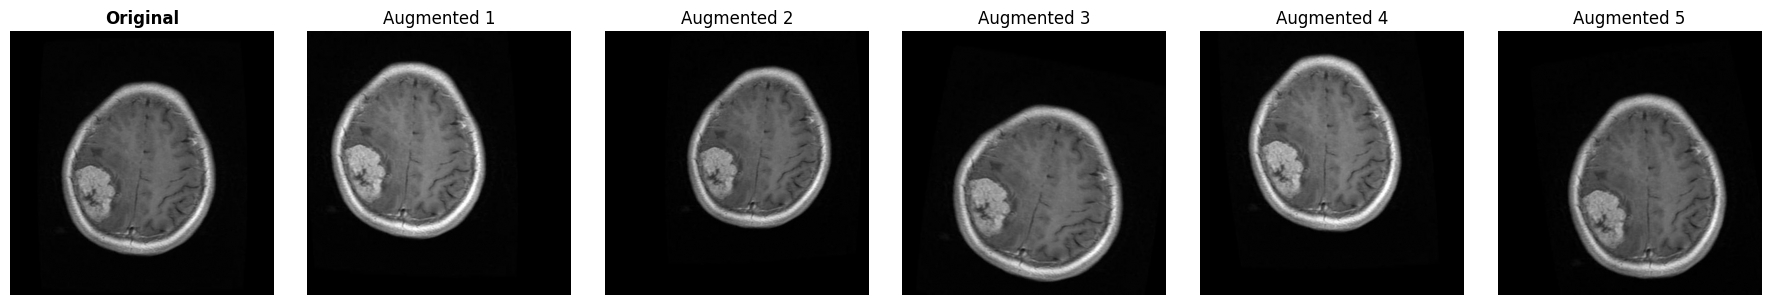

In [12]:
def augment_single_brain_mri(image_path, num_augmentations=5):
    """
    Augment a single brain MRI image and save augmented versions to the same directory.

    Args:
        image_path (str): Full path to the single MRI image
        num_augmentations (int): Number of augmented versions to create
    """

    # Brain MRI specific augmentation configuration
    datagen = ImageDataGenerator(
        rotation_range=15,           # Small rotations (brain orientation matters)
        width_shift_range=0.1,       # Horizontal shifts
        height_shift_range=0.1,      # Vertical shifts
        zoom_range=0.1,              # Slight zoom variations
        shear_range=5,               # Small shear transformations
        brightness_range=[0.8, 1.2], # Brightness variations
        horizontal_flip=False,       # No horizontal flip (brain asymmetry is important)
        vertical_flip=False,         # No vertical flip
        fill_mode='constant',        # Fill with constant value (black)
        cval=0.0,                    # Fill value (black for medical images)
        rescale=None                 # Don't rescale - keep original pixel values
    )

    # Check if image exists
    if not os.path.exists(image_path):
        print(f"Error: Image '{image_path}' does not exist!")
        return

    # Get directory and filename info
    directory = os.path.dirname(image_path)
    filename = os.path.basename(image_path)
    base_name = os.path.splitext(filename)[0]
    extension = os.path.splitext(filename)[1]

    print(f"Processing image: {filename}")
    print(f"Creating {num_augmentations} augmented versions...")

    try:
        # Load and preprocess image
        img = load_img(image_path, color_mode='grayscale')  # Load as grayscale for MRI
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)

        # Keep original range (0-255) - don't normalize for augmentation
        # The ImageDataGenerator works fine with 0-255 range

        # Generate augmented images
        i = 0
        for batch in datagen.flow(x, batch_size=1):
            # Get the augmented image (already in 0-255 range)
            augmented_img = batch[0].astype(np.uint8)

            # Save augmented image
            aug_filename = f"aug_{base_name}_{i+1:02d}{extension}"
            aug_path = os.path.join(directory, aug_filename)

            # Convert array back to PIL Image and save
            if len(augmented_img.shape) == 3 and augmented_img.shape[2] == 1:
                augmented_img = augmented_img.squeeze()

            pil_img = Image.fromarray(augmented_img, mode='L')
            pil_img.save(aug_path)

            print(f"  Saved: {aug_filename}")

            i += 1
            if i >= num_augmentations:
                break

        print(f"\nAugmentation complete!")
        print(f"Generated {num_augmentations} augmented images")
        print(f"Saved in directory: {directory}")

    except Exception as e:
        print(f"Error processing image: {str(e)}")


def display_original_and_augmented(image_path):
    """
    Display the original image alongside its augmented versions.

    Args:
        image_path (str): Path to the original image
    """

    if not os.path.exists(image_path):
        print(f"Error: Image '{image_path}' does not exist!")
        return

    # Get directory and filename info
    directory = os.path.dirname(image_path)
    filename = os.path.basename(image_path)
    base_name = os.path.splitext(filename)[0]
    extension = os.path.splitext(filename)[1]

    # Find corresponding augmented images
    augmented_files = []
    for f in os.listdir(directory):
        if f.startswith(f'aug_{base_name}_') and f.endswith(extension):
            augmented_files.append(f)

    # Sort augmented files for consistent display
    augmented_files.sort()

    if not augmented_files:
        print("No augmented images found! Run augmentation first.")
        return

    print(f"Displaying original + {len(augmented_files)} augmented versions")

    # Load original image
    original_img = load_img(image_path, color_mode='grayscale')

    # Create subplot layout
    num_total = len(augmented_files) + 1  # +1 for original
    cols = min(6, num_total)  # Max 6 columns
    rows = (num_total + cols - 1) // cols  # Calculate needed rows

    fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))

    # Handle single row case
    if rows == 1:
        if cols == 1:
            axes = [axes]
        else:
            axes = axes.reshape(1, -1)

    # Flatten axes for easier indexing
    axes_flat = axes.flatten() if num_total > 1 else [axes]

    # Display original image
    axes_flat[0].imshow(original_img, cmap='gray')
    axes_flat[0].set_title('Original', fontsize=12, fontweight='bold')
    axes_flat[0].axis('off')

    # Display augmented images
    for i, aug_file in enumerate(augmented_files):
        aug_path = os.path.join(directory, aug_file)
        aug_img = load_img(aug_path, color_mode='grayscale')

        axes_flat[i + 1].imshow(aug_img, cmap='gray')
        axes_flat[i + 1].set_title(f'Augmented {i + 1}', fontsize=12)
        axes_flat[i + 1].axis('off')

    # Hide unused subplots
    for i in range(num_total, len(axes_flat)):
        axes_flat[i].axis('off')

    plt.tight_layout()
    plt.show()


# Example usage:
if __name__ == "__main__":
    # Set your image path here
    image_path = "/content/drive/MyDrive/Colab Notebooks/labmentix/Tumour/train/meningioma/Tr-me_0011_jpg.rf.c039f84f918b11f4a74316cd5bb2c231.jpg"  # UPDATE THIS PATH

    print("=== Single Brain MRI Image Augmentation ===")

    # Step 1: Augment the single image
    augment_single_brain_mri(image_path, num_augmentations=5)

    # Step 2: Display results
    print("\nDisplaying results...")
    display_original_and_augmented(image_path)


# Quick usage functions:
def augment_and_show(image_path, num_augmentations=5):
    """Convenience function to augment and display in one go"""
    augment_single_brain_mri(image_path, num_augmentations)
    display_original_and_augmented(image_path)

# Example for Google Colab:
# image_path = "/content/drive/MyDrive/brain_scan.jpg"
# augment_and_show(image_path, 5)

# Augmenting an image from no_tumor directory

=== Single Brain MRI Image Augmentation ===
Processing image: Tr-no_0013_jpg.rf.ba75dd083e4c092e31fd59db1a7de9dc.jpg
Creating 5 augmented versions...


/tmp/ipython-input-13-3830753752.py:62: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  pil_img = Image.fromarray(augmented_img, mode='L')


  Saved: aug_Tr-no_0013_jpg.rf.ba75dd083e4c092e31fd59db1a7de9dc_01.jpg
  Saved: aug_Tr-no_0013_jpg.rf.ba75dd083e4c092e31fd59db1a7de9dc_02.jpg
  Saved: aug_Tr-no_0013_jpg.rf.ba75dd083e4c092e31fd59db1a7de9dc_03.jpg
  Saved: aug_Tr-no_0013_jpg.rf.ba75dd083e4c092e31fd59db1a7de9dc_04.jpg
  Saved: aug_Tr-no_0013_jpg.rf.ba75dd083e4c092e31fd59db1a7de9dc_05.jpg

Augmentation complete!
Generated 5 augmented images
Saved in directory: /content/drive/MyDrive/Colab Notebooks/labmentix/Tumour/train/no_tumor

Displaying results...
Displaying original + 5 augmented versions


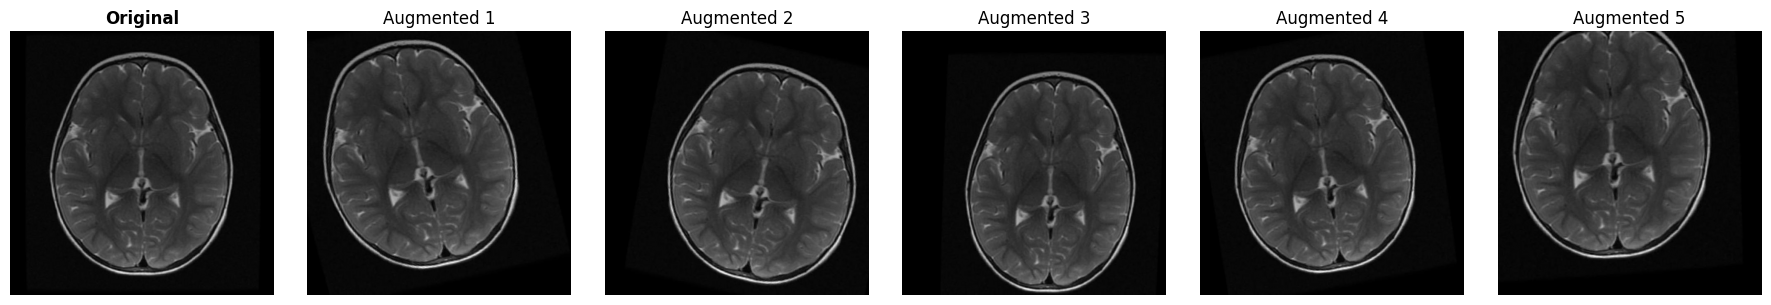

In [13]:
def augment_single_brain_mri(image_path, num_augmentations=5):
    """
    Augment a single brain MRI image and save augmented versions to the same directory.

    Args:
        image_path (str): Full path to the single MRI image
        num_augmentations (int): Number of augmented versions to create
    """

    # Brain MRI specific augmentation configuration
    datagen = ImageDataGenerator(
        rotation_range=15,           # Small rotations (brain orientation matters)
        width_shift_range=0.1,       # Horizontal shifts
        height_shift_range=0.1,      # Vertical shifts
        zoom_range=0.1,              # Slight zoom variations
        shear_range=5,               # Small shear transformations
        brightness_range=[0.8, 1.2], # Brightness variations
        horizontal_flip=False,       # No horizontal flip (brain asymmetry is important)
        vertical_flip=False,         # No vertical flip
        fill_mode='constant',        # Fill with constant value (black)
        cval=0.0,                    # Fill value (black for medical images)
        rescale=None                 # Don't rescale - keep original pixel values
    )

    # Check if image exists
    if not os.path.exists(image_path):
        print(f"Error: Image '{image_path}' does not exist!")
        return

    # Get directory and filename info
    directory = os.path.dirname(image_path)
    filename = os.path.basename(image_path)
    base_name = os.path.splitext(filename)[0]
    extension = os.path.splitext(filename)[1]

    print(f"Processing image: {filename}")
    print(f"Creating {num_augmentations} augmented versions...")

    try:
        # Load and preprocess image
        img = load_img(image_path, color_mode='grayscale')  # Load as grayscale for MRI
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)

        # Keep original range (0-255) - don't normalize for augmentation
        # The ImageDataGenerator works fine with 0-255 range

        # Generate augmented images
        i = 0
        for batch in datagen.flow(x, batch_size=1):
            # Get the augmented image (already in 0-255 range)
            augmented_img = batch[0].astype(np.uint8)

            # Save augmented image
            aug_filename = f"aug_{base_name}_{i+1:02d}{extension}"
            aug_path = os.path.join(directory, aug_filename)

            # Convert array back to PIL Image and save
            if len(augmented_img.shape) == 3 and augmented_img.shape[2] == 1:
                augmented_img = augmented_img.squeeze()

            pil_img = Image.fromarray(augmented_img, mode='L')
            pil_img.save(aug_path)

            print(f"  Saved: {aug_filename}")

            i += 1
            if i >= num_augmentations:
                break

        print(f"\nAugmentation complete!")
        print(f"Generated {num_augmentations} augmented images")
        print(f"Saved in directory: {directory}")

    except Exception as e:
        print(f"Error processing image: {str(e)}")


def display_original_and_augmented(image_path):
    """
    Display the original image alongside its augmented versions.

    Args:
        image_path (str): Path to the original image
    """

    if not os.path.exists(image_path):
        print(f"Error: Image '{image_path}' does not exist!")
        return

    # Get directory and filename info
    directory = os.path.dirname(image_path)
    filename = os.path.basename(image_path)
    base_name = os.path.splitext(filename)[0]
    extension = os.path.splitext(filename)[1]

    # Find corresponding augmented images
    augmented_files = []
    for f in os.listdir(directory):
        if f.startswith(f'aug_{base_name}_') and f.endswith(extension):
            augmented_files.append(f)

    # Sort augmented files for consistent display
    augmented_files.sort()

    if not augmented_files:
        print("No augmented images found! Run augmentation first.")
        return

    print(f"Displaying original + {len(augmented_files)} augmented versions")

    # Load original image
    original_img = load_img(image_path, color_mode='grayscale')

    # Create subplot layout
    num_total = len(augmented_files) + 1  # +1 for original
    cols = min(6, num_total)  # Max 6 columns
    rows = (num_total + cols - 1) // cols  # Calculate needed rows

    fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))

    # Handle single row case
    if rows == 1:
        if cols == 1:
            axes = [axes]
        else:
            axes = axes.reshape(1, -1)

    # Flatten axes for easier indexing
    axes_flat = axes.flatten() if num_total > 1 else [axes]

    # Display original image
    axes_flat[0].imshow(original_img, cmap='gray')
    axes_flat[0].set_title('Original', fontsize=12, fontweight='bold')
    axes_flat[0].axis('off')

    # Display augmented images
    for i, aug_file in enumerate(augmented_files):
        aug_path = os.path.join(directory, aug_file)
        aug_img = load_img(aug_path, color_mode='grayscale')

        axes_flat[i + 1].imshow(aug_img, cmap='gray')
        axes_flat[i + 1].set_title(f'Augmented {i + 1}', fontsize=12)
        axes_flat[i + 1].axis('off')

    # Hide unused subplots
    for i in range(num_total, len(axes_flat)):
        axes_flat[i].axis('off')

    plt.tight_layout()
    plt.show()


# Example usage:
if __name__ == "__main__":
    # Set your image path here
    image_path = "/content/drive/MyDrive/Colab Notebooks/labmentix/Tumour/train/no_tumor/Tr-no_0013_jpg.rf.ba75dd083e4c092e31fd59db1a7de9dc.jpg"  # UPDATE THIS PATH

    print("=== Single Brain MRI Image Augmentation ===")

    # Step 1: Augment the single image
    augment_single_brain_mri(image_path, num_augmentations=5)

    # Step 2: Display results
    print("\nDisplaying results...")
    display_original_and_augmented(image_path)


# Quick usage functions:
def augment_and_show(image_path, num_augmentations=5):
    """Convenience function to augment and display in one go"""
    augment_single_brain_mri(image_path, num_augmentations)
    display_original_and_augmented(image_path)

# Example for Google Colab:
# image_path = "/content/drive/MyDrive/brain_scan.jpg"
# augment_and_show(image_path, 5)

# Augmenting an image from pituitary directory

=== Single Brain MRI Image Augmentation ===
Processing image: Tr-pi_0010_jpg.rf.caed12ef1e5fad2e91a79e5773efc0bb.jpg
Creating 5 augmented versions...


/tmp/ipython-input-14-555122123.py:62: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  pil_img = Image.fromarray(augmented_img, mode='L')


  Saved: aug_Tr-pi_0010_jpg.rf.caed12ef1e5fad2e91a79e5773efc0bb_01.jpg
  Saved: aug_Tr-pi_0010_jpg.rf.caed12ef1e5fad2e91a79e5773efc0bb_02.jpg
  Saved: aug_Tr-pi_0010_jpg.rf.caed12ef1e5fad2e91a79e5773efc0bb_03.jpg
  Saved: aug_Tr-pi_0010_jpg.rf.caed12ef1e5fad2e91a79e5773efc0bb_04.jpg
  Saved: aug_Tr-pi_0010_jpg.rf.caed12ef1e5fad2e91a79e5773efc0bb_05.jpg

Augmentation complete!
Generated 5 augmented images
Saved in directory: /content/drive/MyDrive/Colab Notebooks/labmentix/Tumour/train/pituitary

Displaying results...
Displaying original + 5 augmented versions


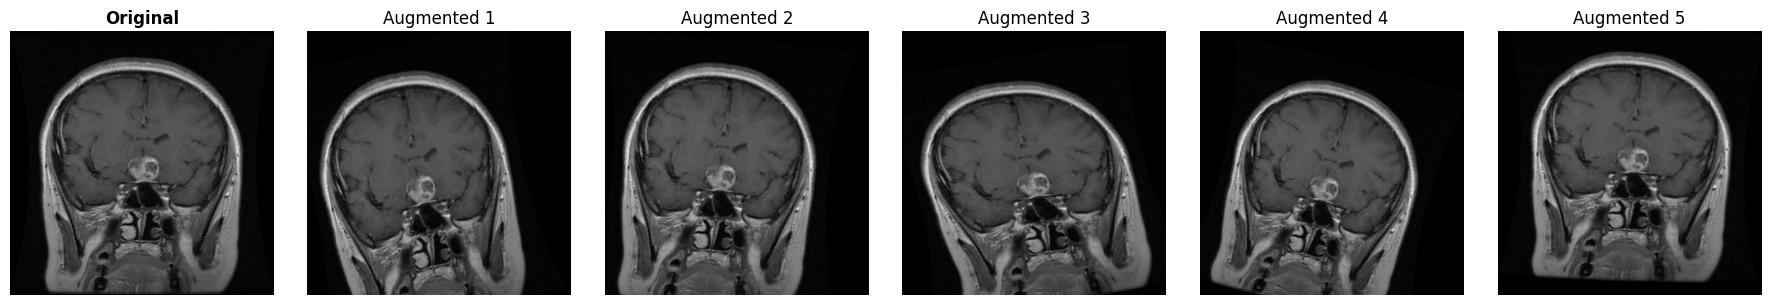

In [14]:
def augment_single_brain_mri(image_path, num_augmentations=5):
    """
    Augment a single brain MRI image and save augmented versions to the same directory.

    Args:
        image_path (str): Full path to the single MRI image
        num_augmentations (int): Number of augmented versions to create
    """

    # Brain MRI specific augmentation configuration
    datagen = ImageDataGenerator(
        rotation_range=15,           # Small rotations (brain orientation matters)
        width_shift_range=0.1,       # Horizontal shifts
        height_shift_range=0.1,      # Vertical shifts
        zoom_range=0.1,              # Slight zoom variations
        shear_range=5,               # Small shear transformations
        brightness_range=[0.8, 1.2], # Brightness variations
        horizontal_flip=False,       # No horizontal flip (brain asymmetry is important)
        vertical_flip=False,         # No vertical flip
        fill_mode='constant',        # Fill with constant value (black)
        cval=0.0,                    # Fill value (black for medical images)
        rescale=None                 # Don't rescale - keep original pixel values
    )

    # Check if image exists
    if not os.path.exists(image_path):
        print(f"Error: Image '{image_path}' does not exist!")
        return

    # Get directory and filename info
    directory = os.path.dirname(image_path)
    filename = os.path.basename(image_path)
    base_name = os.path.splitext(filename)[0]
    extension = os.path.splitext(filename)[1]

    print(f"Processing image: {filename}")
    print(f"Creating {num_augmentations} augmented versions...")

    try:
        # Load and preprocess image
        img = load_img(image_path, color_mode='grayscale')  # Load as grayscale for MRI
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)

        # Keep original range (0-255) - don't normalize for augmentation
        # The ImageDataGenerator works fine with 0-255 range

        # Generate augmented images
        i = 0
        for batch in datagen.flow(x, batch_size=1):
            # Get the augmented image (already in 0-255 range)
            augmented_img = batch[0].astype(np.uint8)

            # Save augmented image
            aug_filename = f"aug_{base_name}_{i+1:02d}{extension}"
            aug_path = os.path.join(directory, aug_filename)

            # Convert array back to PIL Image and save
            if len(augmented_img.shape) == 3 and augmented_img.shape[2] == 1:
                augmented_img = augmented_img.squeeze()

            pil_img = Image.fromarray(augmented_img, mode='L')
            pil_img.save(aug_path)

            print(f"  Saved: {aug_filename}")

            i += 1
            if i >= num_augmentations:
                break

        print(f"\nAugmentation complete!")
        print(f"Generated {num_augmentations} augmented images")
        print(f"Saved in directory: {directory}")

    except Exception as e:
        print(f"Error processing image: {str(e)}")


def display_original_and_augmented(image_path):
    """
    Display the original image alongside its augmented versions.

    Args:
        image_path (str): Path to the original image
    """

    if not os.path.exists(image_path):
        print(f"Error: Image '{image_path}' does not exist!")
        return

    # Get directory and filename info
    directory = os.path.dirname(image_path)
    filename = os.path.basename(image_path)
    base_name = os.path.splitext(filename)[0]
    extension = os.path.splitext(filename)[1]

    # Find corresponding augmented images
    augmented_files = []
    for f in os.listdir(directory):
        if f.startswith(f'aug_{base_name}_') and f.endswith(extension):
            augmented_files.append(f)

    # Sort augmented files for consistent display
    augmented_files.sort()

    if not augmented_files:
        print("No augmented images found! Run augmentation first.")
        return

    print(f"Displaying original + {len(augmented_files)} augmented versions")

    # Load original image
    original_img = load_img(image_path, color_mode='grayscale')

    # Create subplot layout
    num_total = len(augmented_files) + 1  # +1 for original
    cols = min(6, num_total)  # Max 6 columns
    rows = (num_total + cols - 1) // cols  # Calculate needed rows

    fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))

    # Handle single row case
    if rows == 1:
        if cols == 1:
            axes = [axes]
        else:
            axes = axes.reshape(1, -1)

    # Flatten axes for easier indexing
    axes_flat = axes.flatten() if num_total > 1 else [axes]

    # Display original image
    axes_flat[0].imshow(original_img, cmap='gray')
    axes_flat[0].set_title('Original', fontsize=12, fontweight='bold')
    axes_flat[0].axis('off')

    # Display augmented images
    for i, aug_file in enumerate(augmented_files):
        aug_path = os.path.join(directory, aug_file)
        aug_img = load_img(aug_path, color_mode='grayscale')

        axes_flat[i + 1].imshow(aug_img, cmap='gray')
        axes_flat[i + 1].set_title(f'Augmented {i + 1}', fontsize=12)
        axes_flat[i + 1].axis('off')

    # Hide unused subplots
    for i in range(num_total, len(axes_flat)):
        axes_flat[i].axis('off')

    plt.tight_layout()
    plt.show()


# Example usage:
if __name__ == "__main__":
    # Set your image path here
    image_path = "/content/drive/MyDrive/Colab Notebooks/labmentix/Tumour/train/pituitary/Tr-pi_0010_jpg.rf.caed12ef1e5fad2e91a79e5773efc0bb.jpg"  # UPDATE THIS PATH

    print("=== Single Brain MRI Image Augmentation ===")

    # Step 1: Augment the single image
    augment_single_brain_mri(image_path, num_augmentations=5)

    # Step 2: Display results
    print("\nDisplaying results...")
    display_original_and_augmented(image_path)


# Quick usage functions:
def augment_and_show(image_path, num_augmentations=5):
    """Convenience function to augment and display in one go"""
    augment_single_brain_mri(image_path, num_augmentations)
    display_original_and_augmented(image_path)

# Example for Google Colab:
# image_path = "/content/drive/MyDrive/brain_scan.jpg"
# augment_and_show(image_path, 5)

# ***4. MODEL BUILDING***

# Building custon CNN

In [15]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model

model = Sequential()

# First Convolutional Block
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape= (224, 224, 3), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

# Second Convolutional Block
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

# Third Convolutional Block
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

# Fourth Convolutional Block
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

# Fifth Convolutional Block (Deeper feature extraction)
model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(layers.GlobalAveragePooling2D())  # Alternative to Flatten + Dense
model.add(layers.Dropout(0.5))

# Dense Classification Layers
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))

# Output Layer
model.add(layers.Dense(4, activation='softmax'))  # Multi-class

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 14, 14, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 14, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 5,114,276 (19.51 MB)

 Trainable params: 5,110,756 (19.50 MB)

 Non-trainable params: 3,520 (13.75 KB)

# ***5. TRANSFER LEARNING***

# Training ResNet50

In [16]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

num_classes = 4  # Changed from 2 to 4
resnet_weights_path = '../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

my_resnet_model = Sequential()
my_resnet_model.add(ResNet50(include_top=False, pooling='avg', weights='imagenet'))
my_resnet_model.add(Dense(num_classes, activation='softmax'))

# Say not to train first layer (ResNet) model. It is already trained
my_resnet_model.layers[0].trainable = False

my_resnet_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         8,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

# Training MobileNetV2

In [17]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

num_classes = 4  # Adjust based on your dataset

mobilenet_model = Sequential()
mobilenet_model.add(MobileNetV2(include_top=False, pooling='avg', weights='imagenet'))
mobilenet_model.add(Dense(num_classes, activation='softmax'))

# Freeze base model
mobilenet_model.layers[0].trainable = False

mobilenet_model.summary()


/tmp/ipython-input-17-1316017396.py:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_model.add(MobileNetV2(include_top=False, pooling='avg', weights='imagenet'))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Training InceptionV3

In [18]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

num_classes = 4

inception_model = Sequential()
inception_model.add(InceptionV3(include_top=False, pooling='avg', weights='imagenet'))
inception_model.add(Dense(num_classes, activation='softmax'))

# Freeze base model
inception_model.layers[0].trainable = False

inception_model.summary()


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 2048)           │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         8,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,810,980 (83.20 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

# Training EfficientNetB0

In [19]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

num_classes = 4

efficientnet_model = Sequential()
efficientnet_model.add(EfficientNetB0(include_top=False, pooling='avg', weights='imagenet'))
efficientnet_model.add(Dense(num_classes, activation='softmax'))

# Freeze base model
efficientnet_model.layers[0].trainable = False

efficientnet_model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

# ***6. MODEL TRAINING***

# Preparing training and validation data

In [20]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_data = image_dataset_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/labmentix/Tumour/train",
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical"  # or "int" if using sparse_categorical_crossentropy
)

val_data = image_dataset_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/labmentix/Tumour/valid",
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical"
)

Found 1715 files belonging to 4 classes.
Found 502 files belonging to 4 classes.


# Training custom CNN

In [21]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the path where the best model will be saved
checkpoint_path = 'good_model.h5'

# Callback to stop training when validation loss doesn't improve
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Callback to save the model with the best validation loss
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Train the model with callbacks
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    verbose=1,
    callbacks=[early_stopping, model_checkpoint]
)
model.summary()

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.4739 - loss: 1.5146
Epoch 1: val_loss improved from inf to 52.99524, saving model to good_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 260s 4s/step - accuracy: 0.4758 - loss: 1.5096 - val_accuracy: 0.1972 - val_loss: 52.9952
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.6644 - loss: 0.9270
Epoch 2: val_loss improved from 52.99524 to 3.80072, saving model to good_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 217ms/step - accuracy: 0.6647 - loss: 0.9263 - val_accuracy: 0.3924 - val_loss: 3.8007
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.7280 - loss: 0.8020
Epoch 3: val_loss did not improve from 3.80072
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 210ms/step - accuracy: 0.7274 - loss: 0.8036 - val_accuracy: 0.4143 - val_loss: 4.8924
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.7129 - loss: 0.8331
Epoch 4: val_loss improved from 3.80072 to 2.81500, saving model to good_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 198ms/step - accuracy: 0.7130 - loss: 0.8324 - val_accuracy: 0.2251 - val_loss: 2.8150
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.7200 - loss: 0.7916
Epoch 5: val_loss did not improve from 2.81500
54/54 ━━━━━━━━━━━━━━━━━━━━ 21s 211ms/step - accuracy: 0.7202 - loss: 0.7906 - val_accuracy: 0.4522 - val_loss: 3.7930
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.7558 - loss: 0.6452
Epoch 6: val_loss did not improve from 2.81500
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 210ms/step - accuracy: 0.7559 - loss: 0.6452 - val_accuracy: 0.4900 - val_loss: 3.0833
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.7950 - loss: 0.5446
Epoch 7: val_loss improved from 2.81500 to 1.66402, saving model to good_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 215ms/step - accuracy: 0.7950 - loss: 0.5452 - val_accuracy: 0.5916 - val_loss: 1.6640
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.7822 - loss: 0.5724
Epoch 8: val_loss did not improve from 1.66402
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 211ms/step - accuracy: 0.7822 - loss: 0.5722 - val_accuracy: 0.5896 - val_loss: 2.4620
Epoch 9/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.7745 - loss: 0.6164
Epoch 9: val_loss did not improve from 1.66402
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 212ms/step - accuracy: 0.7745 - loss: 0.6161 - val_accuracy: 0.4641 - val_loss: 10.2883
Epoch 10/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.8219 - loss: 0.4909
Epoch 10: val_loss did not improve from 1.66402
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 195ms/step - accuracy: 0.8216 - loss: 0.4915 - val_accuracy: 0.4821 - val_loss: 10.4934
Epoch 11/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.8120 - loss: 0.4882
Epoch 11: val_loss improved from 1.664

54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 214ms/step - accuracy: 0.8122 - loss: 0.4882 - val_accuracy: 0.6534 - val_loss: 1.6462
Epoch 12/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.8348 - loss: 0.4484
Epoch 12: val_loss did not improve from 1.64616
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 190ms/step - accuracy: 0.8346 - loss: 0.4486 - val_accuracy: 0.5837 - val_loss: 2.2487
Epoch 13/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.8585 - loss: 0.3866
Epoch 13: val_loss improved from 1.64616 to 0.67563, saving model to good_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 217ms/step - accuracy: 0.8583 - loss: 0.3868 - val_accuracy: 0.7191 - val_loss: 0.6756
Epoch 14/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.8340 - loss: 0.4132
Epoch 14: val_loss did not improve from 0.67563
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 195ms/step - accuracy: 0.8340 - loss: 0.4138 - val_accuracy: 0.4104 - val_loss: 4.3619
Epoch 15/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.8787 - loss: 0.3544
Epoch 15: val_loss did not improve from 0.67563
54/54 ━━━━━━━━━━━━━━━━━━━━ 21s 205ms/step - accuracy: 0.8783 - loss: 0.3551 - val_accuracy: 0.4761 - val_loss: 2.7472
Epoch 16/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.8696 - loss: 0.3272
Epoch 16: val_loss did not improve from 0.67563
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 210ms/step - accuracy: 0.8694 - loss: 0.3275 - val_accuracy: 0.6693 - val_loss: 1.1226
Epoch 17/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.8723 - loss: 0.3253
Epoch 17: val_loss did not improve f

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 14, 14, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 14, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 15,335,790 (58.50 MB)

 Trainable params: 5,110,756 (19.50 MB)

 Non-trainable params: 3,520 (13.75 KB)

 Optimizer params: 10,221,514 (38.99 MB)

# Visualsing training and validation loss and accuracy of model

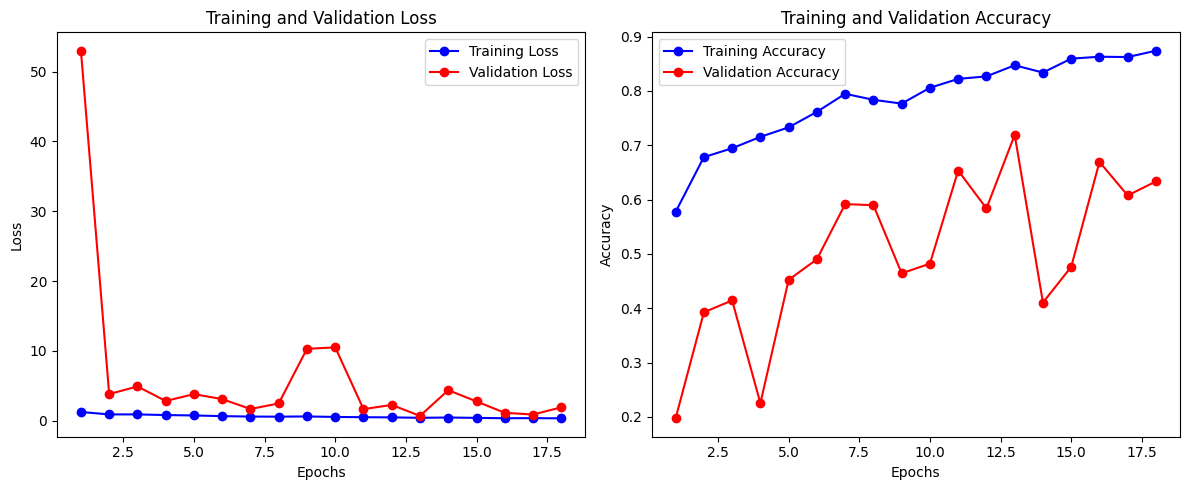

In [22]:
#displaying model metrics
model.metrics_names

#converting model history to pandas dataframe for analysis
import pandas as pd
metrics=pd.DataFrame(model.history.history)

metrics.head()

import matplotlib.pyplot as plt

# Extract metrics from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Create a range of epochs for the x-axis
epochs = range(1, len(train_loss) + 1)

# Plot Training and Validation Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Training ResNet50

In [23]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Compile the model before training
my_resnet_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define the path where the best model will be saved
my_resnet_model_checkpoint_path = 'good_resnet_model.h5'

# Callback to stop training when validation loss doesn't improve
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Callback to save the model with the best validation loss
my_resnet_model_checkpoint = ModelCheckpoint(
    filepath=my_resnet_model_checkpoint_path, # Changed filepath
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

my_resnet_history = my_resnet_model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    verbose=1,
    callbacks=[early_stopping, my_resnet_model_checkpoint] # Changed checkpoint callback
)

# Display model summary
my_resnet_model.summary()

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.3432 - loss: 1.5858
Epoch 1: val_loss improved from inf to 1.06652, saving model to good_resnet_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 35s 430ms/step - accuracy: 0.3450 - loss: 1.5809 - val_accuracy: 0.5976 - val_loss: 1.0665
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.6531 - loss: 0.9491
Epoch 2: val_loss improved from 1.06652 to 0.86842, saving model to good_resnet_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 21s 160ms/step - accuracy: 0.6536 - loss: 0.9482 - val_accuracy: 0.6514 - val_loss: 0.8684
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.7176 - loss: 0.7686
Epoch 3: val_loss improved from 0.86842 to 0.74506, saving model to good_resnet_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 168ms/step - accuracy: 0.7181 - loss: 0.7681 - val_accuracy: 0.7012 - val_loss: 0.7451
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.7879 - loss: 0.6502
Epoch 4: val_loss improved from 0.74506 to 0.66211, saving model to good_resnet_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 214ms/step - accuracy: 0.7881 - loss: 0.6500 - val_accuracy: 0.7291 - val_loss: 0.6621
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.8206 - loss: 0.5705
Epoch 5: val_loss improved from 0.66211 to 0.60433, saving model to good_resnet_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 183ms/step - accuracy: 0.8207 - loss: 0.5705 - val_accuracy: 0.7490 - val_loss: 0.6043
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.8488 - loss: 0.5094
Epoch 6: val_loss improved from 0.60433 to 0.55834, saving model to good_resnet_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 221ms/step - accuracy: 0.8487 - loss: 0.5095 - val_accuracy: 0.7689 - val_loss: 0.5583
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.8641 - loss: 0.4593
Epoch 7: val_loss improved from 0.55834 to 0.52681, saving model to good_resnet_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - accuracy: 0.8640 - loss: 0.4596 - val_accuracy: 0.7908 - val_loss: 0.5268
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.8738 - loss: 0.4243
Epoch 8: val_loss improved from 0.52681 to 0.50293, saving model to good_resnet_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 231ms/step - accuracy: 0.8736 - loss: 0.4245 - val_accuracy: 0.8108 - val_loss: 0.5029
Epoch 9/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.8867 - loss: 0.4062
Epoch 9: val_loss improved from 0.50293 to 0.48390, saving model to good_resnet_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 17s 170ms/step - accuracy: 0.8865 - loss: 0.4062 - val_accuracy: 0.8227 - val_loss: 0.4839
Epoch 10/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.8921 - loss: 0.3715
Epoch 10: val_loss improved from 0.48390 to 0.45912, saving model to good_resnet_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 268ms/step - accuracy: 0.8920 - loss: 0.3718 - val_accuracy: 0.8386 - val_loss: 0.4591
Epoch 11/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.8965 - loss: 0.3540
Epoch 11: val_loss improved from 0.45912 to 0.44760, saving model to good_resnet_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 172ms/step - accuracy: 0.8964 - loss: 0.3542 - val_accuracy: 0.8406 - val_loss: 0.4476
Epoch 12/20
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.9095 - loss: 0.3338
Epoch 12: val_loss improved from 0.44760 to 0.42832, saving model to good_resnet_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 13s 230ms/step - accuracy: 0.9091 - loss: 0.3342 - val_accuracy: 0.8546 - val_loss: 0.4283
Epoch 13/20
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.9121 - loss: 0.3240
Epoch 13: val_loss improved from 0.42832 to 0.40947, saving model to good_resnet_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 21s 232ms/step - accuracy: 0.9121 - loss: 0.3243 - val_accuracy: 0.8685 - val_loss: 0.4095
Epoch 14/20
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9121 - loss: 0.3042
Epoch 14: val_loss improved from 0.40947 to 0.39752, saving model to good_resnet_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 159ms/step - accuracy: 0.9121 - loss: 0.3047 - val_accuracy: 0.8705 - val_loss: 0.3975
Epoch 15/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9176 - loss: 0.2974
Epoch 15: val_loss improved from 0.39752 to 0.39502, saving model to good_resnet_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 0.9175 - loss: 0.2975 - val_accuracy: 0.8685 - val_loss: 0.3950
Epoch 16/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9299 - loss: 0.2717
Epoch 16: val_loss improved from 0.39502 to 0.38840, saving model to good_resnet_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 170ms/step - accuracy: 0.9297 - loss: 0.2721 - val_accuracy: 0.8725 - val_loss: 0.3884
Epoch 17/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9213 - loss: 0.2744
Epoch 17: val_loss improved from 0.38840 to 0.37614, saving model to good_resnet_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 183ms/step - accuracy: 0.9213 - loss: 0.2745 - val_accuracy: 0.8725 - val_loss: 0.3761
Epoch 18/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9220 - loss: 0.2588
Epoch 18: val_loss improved from 0.37614 to 0.36500, saving model to good_resnet_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 176ms/step - accuracy: 0.9219 - loss: 0.2591 - val_accuracy: 0.8865 - val_loss: 0.3650
Epoch 19/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.9328 - loss: 0.2432
Epoch 19: val_loss improved from 0.36500 to 0.36233, saving model to good_resnet_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step - accuracy: 0.9327 - loss: 0.2436 - val_accuracy: 0.8825 - val_loss: 0.3623
Epoch 20/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.9263 - loss: 0.2453
Epoch 20: val_loss improved from 0.36233 to 0.35142, saving model to good_resnet_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 0.9263 - loss: 0.2454 - val_accuracy: 0.8884 - val_loss: 0.3514
Restoring model weights from the end of the best epoch: 20.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         8,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,612,302 (90.07 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 16,394 (64.04 KB)

# Visualsing training and validation loss and accuracy of ResNet50

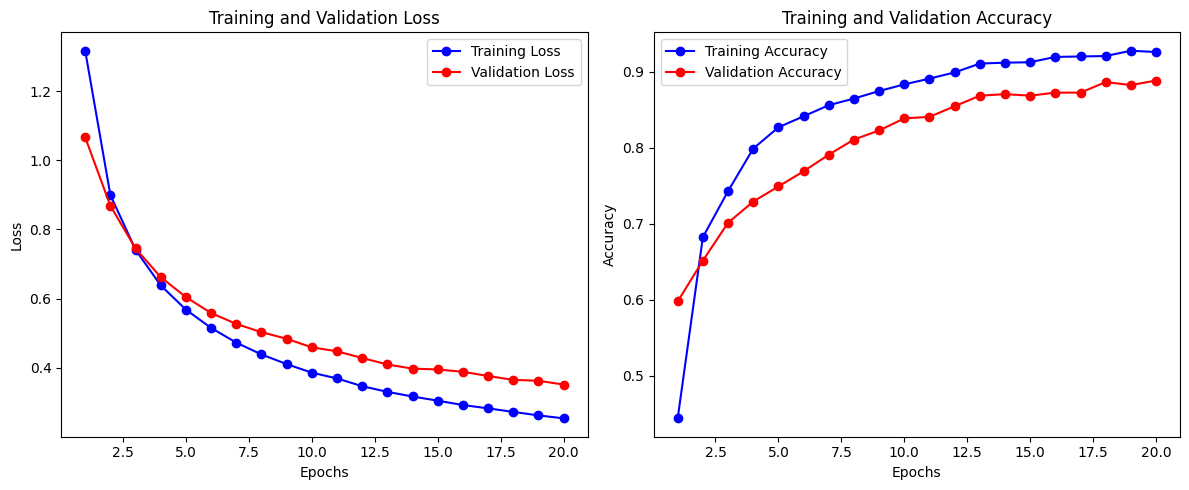

In [24]:
#displaying model metrics
my_resnet_model.metrics_names

#converting model history to pandas dataframe for analysis
import pandas as pd
my_resnet_metrics=pd.DataFrame(model.history.history)

my_resnet_metrics.head()

import matplotlib.pyplot as plt

# Extract metrics from the history object
train_loss = my_resnet_history.history['loss']
val_loss = my_resnet_history.history['val_loss']
train_acc = my_resnet_history.history['accuracy']
val_acc = my_resnet_history.history['val_accuracy']

# Create a range of epochs for the x-axis
epochs = range(1, len(train_loss) + 1)

# Plot Training and Validation Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Training MobileNetV2

In [25]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the path where the best model will be saved
mobilenet_checkpoint_path = 'good_mobilenet_model.h5'

# Compile the model before training
mobilenet_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',  # Use 'binary_crossentropy' for binary classification
    metrics=['accuracy']
)

# Callback to stop training when validation loss doesn't improve
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Callback to save the model with the best validation loss
mobilenet_model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Train the model with callbacks
mobilenet_history = mobilenet_model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    verbose=1,
    callbacks=[early_stopping, model_checkpoint]
)
mobilenet_model.summary()

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.3805 - loss: 1.7483
Epoch 1: val_loss did not improve from 0.67563
54/54 ━━━━━━━━━━━━━━━━━━━━ 36s 490ms/step - accuracy: 0.3809 - loss: 1.7445 - val_accuracy: 0.4422 - val_loss: 1.1774
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.5071 - loss: 1.1153
Epoch 2: val_loss did not improve from 0.67563
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 198ms/step - accuracy: 0.5077 - loss: 1.1142 - val_accuracy: 0.5936 - val_loss: 0.9585
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.6178 - loss: 0.9074
Epoch 3: val_loss did not improve from 0.67563
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 169ms/step - accuracy: 0.6186 - loss: 0.9069 - val_accuracy: 0.6594 - val_loss: 0.8403
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7318 - loss: 0.7731 
Epoch 4: val_loss did not improve from 0.67563
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - accuracy: 0.7317 - loss: 0.7732 - val_accuracy: 0.7072 - val_loss: 0.7771

54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 190ms/step - accuracy: 0.7995 - loss: 0.6314 - val_accuracy: 0.7510 - val_loss: 0.6741
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.8030 - loss: 0.6173
Epoch 8: val_loss improved from 0.67413 to 0.64922, saving model to good_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - accuracy: 0.8030 - loss: 0.6173 - val_accuracy: 0.7590 - val_loss: 0.6492
Epoch 9/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.8142 - loss: 0.5770
Epoch 9: val_loss improved from 0.64922 to 0.62918, saving model to good_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 169ms/step - accuracy: 0.8140 - loss: 0.5774 - val_accuracy: 0.7669 - val_loss: 0.6292
Epoch 10/20
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.8187 - loss: 0.5572
Epoch 10: val_loss improved from 0.62918 to 0.61444, saving model to good_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 0.8186 - loss: 0.5580 - val_accuracy: 0.7709 - val_loss: 0.6144
Epoch 11/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.8227 - loss: 0.5406
Epoch 11: val_loss improved from 0.61444 to 0.59861, saving model to good_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 178ms/step - accuracy: 0.8226 - loss: 0.5410 - val_accuracy: 0.7769 - val_loss: 0.5986
Epoch 12/20
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.8228 - loss: 0.5315
Epoch 12: val_loss improved from 0.59861 to 0.58213, saving model to good_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 200ms/step - accuracy: 0.8229 - loss: 0.5320 - val_accuracy: 0.7928 - val_loss: 0.5821
Epoch 13/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.8334 - loss: 0.5163
Epoch 13: val_loss improved from 0.58213 to 0.57392, saving model to good_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 207ms/step - accuracy: 0.8333 - loss: 0.5166 - val_accuracy: 0.7908 - val_loss: 0.5739
Epoch 14/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.8423 - loss: 0.4921
Epoch 14: val_loss improved from 0.57392 to 0.55878, saving model to good_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 178ms/step - accuracy: 0.8421 - loss: 0.4926 - val_accuracy: 0.7968 - val_loss: 0.5588
Epoch 15/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.8431 - loss: 0.4822
Epoch 15: val_loss improved from 0.55878 to 0.55185, saving model to good_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 212ms/step - accuracy: 0.8430 - loss: 0.4827 - val_accuracy: 0.7928 - val_loss: 0.5519
Epoch 16/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.8479 - loss: 0.4709
Epoch 16: val_loss improved from 0.55185 to 0.54233, saving model to good_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 210ms/step - accuracy: 0.8477 - loss: 0.4713 - val_accuracy: 0.7948 - val_loss: 0.5423
Epoch 17/20
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.8516 - loss: 0.4676
Epoch 17: val_loss improved from 0.54233 to 0.53189, saving model to good_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 168ms/step - accuracy: 0.8512 - loss: 0.4683 - val_accuracy: 0.8028 - val_loss: 0.5319
Epoch 18/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.8446 - loss: 0.4538
Epoch 18: val_loss improved from 0.53189 to 0.52635, saving model to good_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 21s 371ms/step - accuracy: 0.8445 - loss: 0.4542 - val_accuracy: 0.8028 - val_loss: 0.5264
Epoch 19/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.8509 - loss: 0.4432
Epoch 19: val_loss improved from 0.52635 to 0.51807, saving model to good_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 172ms/step - accuracy: 0.8507 - loss: 0.4436 - val_accuracy: 0.8048 - val_loss: 0.5181
Epoch 20/20
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.8601 - loss: 0.4226
Epoch 20: val_loss improved from 0.51807 to 0.51122, saving model to good_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 156ms/step - accuracy: 0.8595 - loss: 0.4240 - val_accuracy: 0.8147 - val_loss: 0.5112
Restoring model weights from the end of the best epoch: 20.


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,273,358 (8.67 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 10,250 (40.04 KB)

# Visualsing training and validation loss and accuracy of MobileNetV2

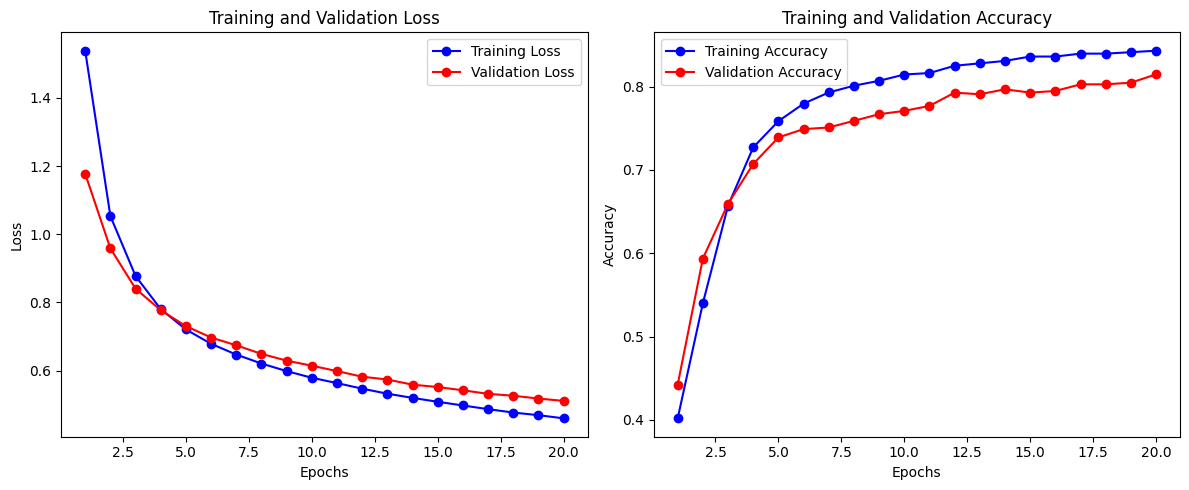

In [26]:
#displaying model metrics
mobilenet_model.metrics_names

#converting model history to pandas dataframe for analysis
import pandas as pd
mobilenet_metrics=pd.DataFrame(mobilenet_model.history.history)

mobilenet_metrics.head()

import matplotlib.pyplot as plt

# Extract metrics from the history object
train_loss = mobilenet_history.history['loss']
val_loss = mobilenet_history.history['val_loss']
train_acc = mobilenet_history.history['accuracy']
val_acc = mobilenet_history.history['val_accuracy']

# Create a range of epochs for the x-axis
epochs = range(1, len(train_loss) + 1)

# Plot Training and Validation Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Training InceptionV3

In [27]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the path where the best model will be saved
inception_checkpoint_path = 'good_inception_model.h5'

# Compile the model before training
inception_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',  # Use 'binary_crossentropy' for binary classification
    metrics=['accuracy']
)

# Callback to stop training when validation loss doesn't improve
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Callback to save the model with the best validation loss
inception_model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Train the model with callbacks
inception_history = inception_model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    verbose=1,
    callbacks=[early_stopping, model_checkpoint]
)
inception_model.summary()

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.2897 - loss: 6.5831
Epoch 1: val_loss did not improve from 0.51122
54/54 ━━━━━━━━━━━━━━━━━━━━ 56s 734ms/step - accuracy: 0.2904 - loss: 6.5585 - val_accuracy: 0.4124 - val_loss: 3.6447
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.3988 - loss: 3.6228
Epoch 2: val_loss did not improve from 0.51122
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 181ms/step - accuracy: 0.3991 - loss: 3.6172 - val_accuracy: 0.4681 - val_loss: 2.9039
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.4554 - loss: 2.7260
Epoch 3: val_loss did not improve from 0.51122
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 193ms/step - accuracy: 0.4558 - loss: 2.7234 - val_accuracy: 0.5378 - val_loss: 2.5152
Epoch 4/20
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.4991 - loss: 2.2523
Epoch 4: val_loss did not improve from 0.51122
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - accuracy: 0.5000 - loss: 2.2480 - val_accuracy: 0.5797 - val_loss: 2.31

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 2048)           │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         8,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,827,374 (83.26 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

 Optimizer params: 16,394 (64.04 KB)

# Visualsing training and validation loss and accuracy of InceptionV3

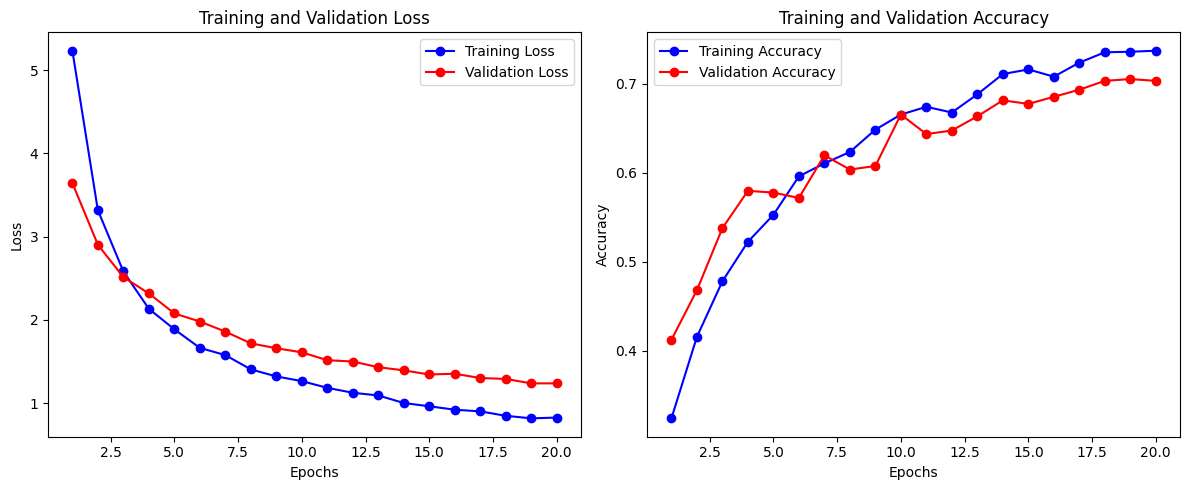

In [28]:
#displaying model metrics
inception_model.metrics_names

#converting model history to pandas dataframe for analysis
import pandas as pd
inception_metrics=pd.DataFrame(inception_model.history.history)

inception_metrics.head()

import matplotlib.pyplot as plt

# Extract metrics from the history object
train_loss = inception_history.history['loss']
val_loss = inception_history.history['val_loss']
train_acc = inception_history.history['accuracy']
val_acc = inception_history.history['val_accuracy']

# Create a range of epochs for the x-axis
epochs = range(1, len(train_loss) + 1)

# Plot Training and Validation Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Training EfficientNetB0

In [29]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the path where the best model will be saved
efficientnet_checkpoint_path = 'good_efficientnet_model.h5'

# Compile the model before training
efficientnet_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',  # Use 'binary_crossentropy' for binary classification
    metrics=['accuracy']
)

# Callback to stop training when validation loss doesn't improve
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Callback to save the model with the best validation loss
efficientnet_model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Train the model with callbacks
efficientnet_history = efficientnet_model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    verbose=1,
    callbacks=[early_stopping, model_checkpoint]
)
efficientnet_model.summary()

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.4060 - loss: 1.2810
Epoch 1: val_loss did not improve from 0.51122
54/54 ━━━━━━━━━━━━━━━━━━━━ 49s 538ms/step - accuracy: 0.4071 - loss: 1.2799 - val_accuracy: 0.5259 - val_loss: 1.1565
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.5692 - loss: 1.0908
Epoch 2: val_loss did not improve from 0.51122
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 161ms/step - accuracy: 0.5700 - loss: 1.0900 - val_accuracy: 0.6155 - val_loss: 1.0226
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.6728 - loss: 0.9596
Epoch 3: val_loss did not improve from 0.51122
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 170ms/step - accuracy: 0.6729 - loss: 0.9593 - val_accuracy: 0.6474 - val_loss: 0.9222
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.7050 - loss: 0.8545
Epoch 4: val_loss did not improve from 0.51122
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 170ms/step - accuracy: 0.7051 - loss: 0.8544 - val_accuracy: 0.6693 - val_loss: 0.847

54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 604ms/step - accuracy: 0.8588 - loss: 0.4666 - val_accuracy: 0.8347 - val_loss: 0.5001
Epoch 17/20
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.8670 - loss: 0.4429
Epoch 17: val_loss improved from 0.50015 to 0.48908, saving model to good_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 181ms/step - accuracy: 0.8667 - loss: 0.4437 - val_accuracy: 0.8347 - val_loss: 0.4891
Epoch 18/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8723 - loss: 0.4386
Epoch 18: val_loss improved from 0.48908 to 0.47641, saving model to good_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 172ms/step - accuracy: 0.8721 - loss: 0.4387 - val_accuracy: 0.8406 - val_loss: 0.4764
Epoch 19/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8736 - loss: 0.4316
Epoch 19: val_loss improved from 0.47641 to 0.46837, saving model to good_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - accuracy: 0.8734 - loss: 0.4318 - val_accuracy: 0.8446 - val_loss: 0.4684
Epoch 20/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.8699 - loss: 0.4206
Epoch 20: val_loss improved from 0.46837 to 0.45903, saving model to good_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step - accuracy: 0.8697 - loss: 0.4207 - val_accuracy: 0.8486 - val_loss: 0.4590
Restoring model weights from the end of the best epoch: 20.


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,064,945 (15.51 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 10,250 (40.04 KB)

# Visualsing training and validation loss and accuracy of EfficientNetB0

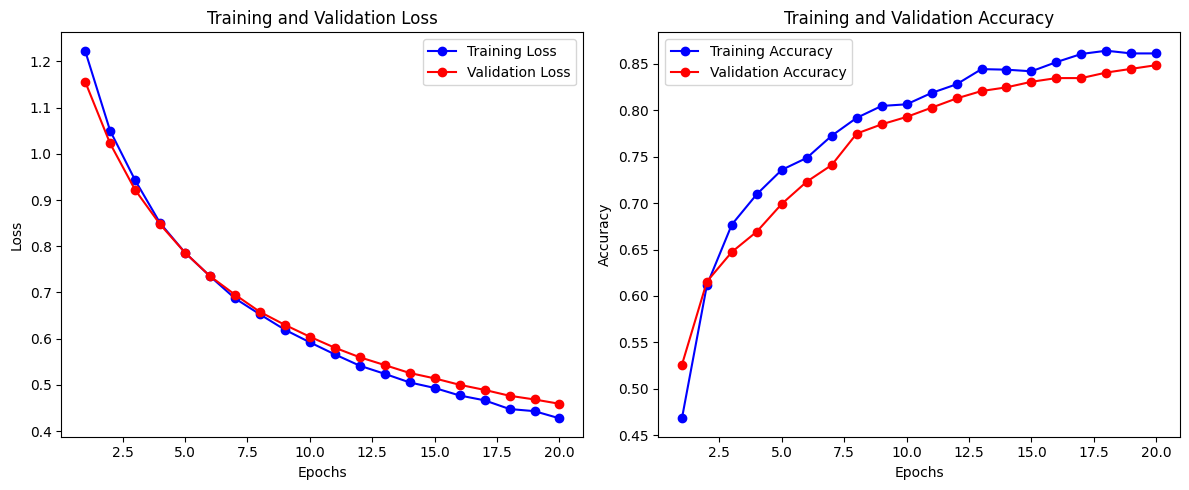

In [30]:
#displaying model metrics
efficientnet_model.metrics_names

#converting model history to pandas dataframe for analysis
import pandas as pd
efficientnet_metrics=pd.DataFrame(inception_model.history.history)

efficientnet_metrics.head()

import matplotlib.pyplot as plt

# Extract metrics from the history object
train_loss = efficientnet_history.history['loss']
val_loss = efficientnet_history.history['val_loss']
train_acc = efficientnet_history.history['accuracy']
val_acc = efficientnet_history.history['val_accuracy']

# Create a range of epochs for the x-axis
epochs = range(1, len(train_loss) + 1)

# Plot Training and Validation Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# ***7. MODEL EVALUATION***

# Printing labels

In [36]:
labels_test=os.listdir(test_data)
print(labels_test)
# labels = labels[1:] # Removed this line
print("Labels for analysis:",labels_test)

['_classes.csv', 'no_tumor', 'pituitary', 'meningioma', 'glioma']
Labels for analysis: ['_classes.csv', 'no_tumor', 'pituitary', 'meningioma', 'glioma']


# Resizing

In [45]:
import os
import cv2
import numpy as np

def get_data_corrected(data_dir, target_size=(224, 224)):
    """Loads and resizes images from a directory, and returns images and numerical labels along with the class names."""
    labels = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))] # Exclude non-directory files
    labels.sort() # Ensure consistent order
    print(f"Labels found: {labels}")

    data = []
    for class_num, label in enumerate(labels):
        path = os.path.join(data_dir, label)
        for img in os.listdir(path):
            if img.lower().endswith(('.jpg', '.jpeg', '.png')):
                try:
                    img_path = os.path.join(path, img)
                    img_array = cv2.imread(img_path) # Load as color image (BGR)
                    img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB) # Convert to RGB
                    img_resized = cv2.resize(img_array, target_size)  # Resize to target_size
                    data.append([img_resized, class_num])  # Append resized img_array and class_num
                except Exception as e:
                    print(f"Error loading or processing image {img_path}: {e}")
    return np.array(data, dtype=object), labels # Also return the corrected labels list

# Normalisation and label encoding

In [48]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import cv2 # Import cv2 here

# Load and preprocess test data
test_data_loaded, labels_test = get_data_corrected(test_data)

# Separate features and labels
x_test = np.array([item[0] for item in test_data_loaded])
y_test = np.array([item[1] for item in test_data_loaded])

# Normalize pixel values to 0-1 scale
x_test = x_test / 255.0

# One-hot encode the labels
y_cat_test = to_categorical(y_test, num_classes=len(labels_test))

print("Shape of x_test:", x_test.shape)
print("Shape of y_test:", y_test.shape)
print("Shape of y_cat_test:", y_cat_test.shape)

Labels found: ['glioma', 'meningioma', 'no_tumor', 'pituitary']
Shape of x_test_corrected: (246, 224, 224, 3)
Shape of y_test_corrected: (246,)
Shape of y_cat_test_corrected: (246, 4)


# Loading custom model

In [53]:
model=keras.models.load_model('good_model.h5')

# Evaluation through classification report and confusion metrics

Class names from validation data: ['glioma', 'meningioma', 'no_tumor', 'pituitary']



Custom CNN Model - Test Loss: 1.3754, Test Accuracy: 0.3252
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 952ms/step

Custom CNN Model - Classification Report:
              precision    recall  f1-score   support

      glioma       0.33      1.00      0.49        80
  meningioma       0.00      0.00      0.00        63
    no_tumor       0.00      0.00      0.00        49
   pituitary       0.00      0.00      0.00        54

    accuracy                           0.33       246
   macro avg       0.08      0.25      0.12       246
weighted avg       0.11      0.33      0.16       246


Custom CNN Model - Confusion Matrix:
[[80  0  0  0]
 [63  0  0  0]
 [49  0  0  0]
 [54  0  0  0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


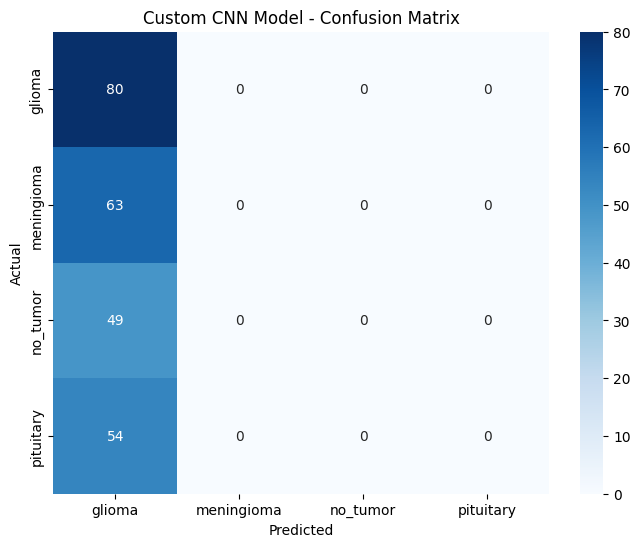

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam # Import Adam

# Assuming 'model' is your trained custom CNN model
# Assuming 'x_test_corrected' and 'y_test_corrected' contain your preprocessed test data and true labels
# Assuming 'labels_test_corrected' contains the correct list of class names for the test data

# Get the class names from the validation dataset
classes = val_data.class_names
print("Class names from validation data:", classes)

# Load the model with custom objects for the optimizer
model = load_model('good_model.h5', custom_objects={'Adam': Adam})


# Evaluate the custom CNN model on the test data
loss, accuracy = model.evaluate(x_test_corrected, y_cat_test_corrected, verbose=0)
print(f"\nCustom CNN Model - Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Get predictions for the classification report and confusion matrix
y_pred_model = model.predict(x_test_corrected)
y_pred_classes_model = np.argmax(y_pred_model, axis=1)

# Generate and print the classification report using corrected labels
class_report_model = classification_report(y_test_corrected, y_pred_classes_model, target_names=labels_test_corrected)
print("\nCustom CNN Model - Classification Report:")
print(class_report_model)

# Generate and print the confusion matrix using corrected labels
conf_matrix_model = confusion_matrix(y_test_corrected, y_pred_classes_model)
print("\nCustom CNN Model - Confusion Matrix:")
print(conf_matrix_model)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_model, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_test_corrected,
            yticklabels=labels_test_corrected)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Custom CNN Model - Confusion Matrix')
plt.show()

# Loading ResNet50

In [58]:
model_resnet=keras.models.load_model('good_resnet_model.h5')

# Evaluation through classification report and confusion metrics





Class names from validation data: ['glioma', 'meningioma', 'no_tumor', 'pituitary']

EVALUATING RESNET MODEL ON TEST DATA
Evaluating model performance...
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.5981 - loss: 1.5930

ResNet Model - Test Loss: 2.7063, Test Accuracy: 0.3252

Generating predictions on test data...
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step
Test samples: 246
Predictions generated: 246

COMPREHENSIVE EVALUATION METRICS
Accuracy:  0.3252
Precision: 0.0813 (macro avg)
Recall:    0.2500 (macro avg)
F1-Score:  0.1227 (macro avg)

DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

      glioma       0.33      1.00      0.49        80
  meningioma       0.00      0.00      0.00        63
    no_tumor       0.00      0.00      0.00        49
   pituitary       0.00      0.00      0.00        54

    accuracy                           0.33       246
   macro avg       0.08      0.25      0.12       246
weighted avg       0.11      0.33      0

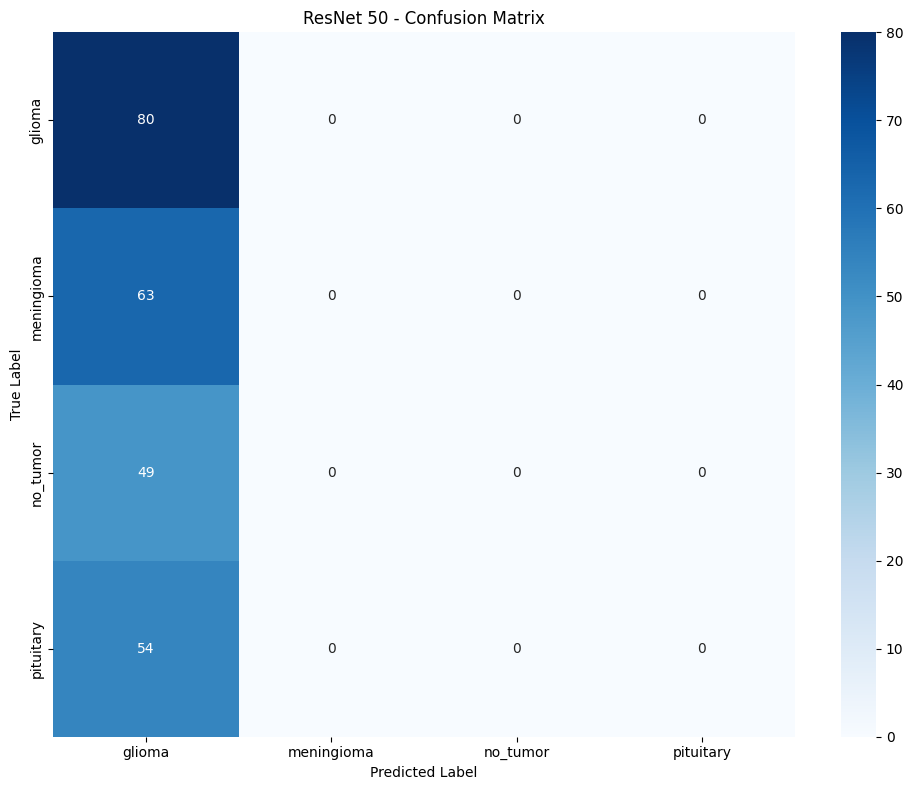


PER-CLASS METRICS BREAKDOWN

glioma:
  True samples: 80
  Predicted samples: 246
  Correct predictions: 80
  Precision: 0.3252
  Recall:    1.0000
  F1-Score:  0.4908

meningioma:
  True samples: 63
  Predicted samples: 0
  Correct predictions: 0
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000

no_tumor:
  True samples: 49
  Predicted samples: 0
  Correct predictions: 0
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000

pituitary:
  True samples: 54
  Predicted samples: 0
  Correct predictions: 0
  Precision: 0.0000
  Recall:    0.0000
  F1-Score:  0.0000

PER-CLASS ACCURACY
glioma: 1.0000
meningioma: 0.0000
no_tumor: 0.0000
pituitary: 0.0000

SAMPLE PREDICTIONS
First 10 predictions vs actual:
Index | Predicted      | Actual         | Correct
--------------------------------------------------
    0 | glioma         | glioma         | ✓
    1 | glioma         | glioma         | ✓
    2 | glioma         | glioma         | ✓
    3 | glioma         | glioma         |

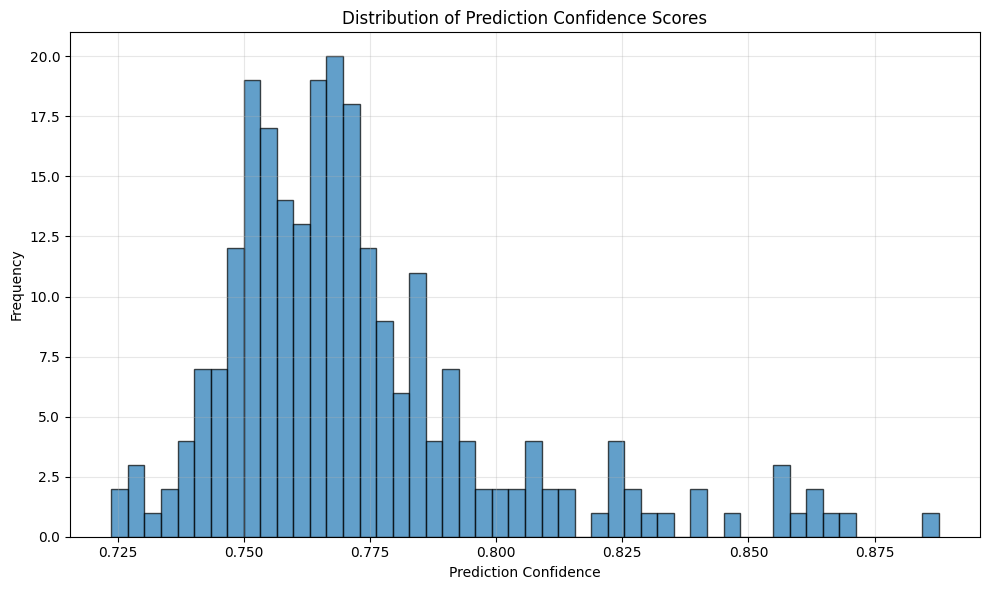


FINAL EVALUATION SUMMARY
Total Test Samples: 246
Number of Classes: 4
Overall Test Accuracy: 0.3252
Overall Test Precision: 0.0813
Overall Test Recall: 0.2500
Overall Test F1-Score: 0.1227
Average Prediction Confidence: 0.7727


In [64]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
from tensorflow.keras.models import load_model

# Get the class names from the validation dataset
classes = val_data.class_names
print("Class names from validation data:", classes)

# Use the existing trained ResNet model for prediction and evaluation
print("\n" + "="*60)
print("EVALUATING RESNET MODEL ON TEST DATA")
print("="*60)

# Evaluate the ResNet model on the test data
print("Evaluating model performance...")
loss, accuracy = model_resnet.evaluate(x_test_corrected, y_cat_test_corrected, verbose=1)
print(f"\nResNet Model - Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Get predictions for detailed evaluation
print("\nGenerating predictions on test data...")
y_pred_model = model_resnet.predict(x_test_corrected, verbose=1)
y_pred_classes_model = np.argmax(y_pred_model, axis=1)

# Convert y_cat_test to class indices if it's one-hot encoded
if len(y_cat_test_corrected.shape) > 1 and y_cat_test_corrected.shape[1] > 1:
    y_test_classes = np.argmax(y_cat_test_corrected, axis=1)
else:
    y_test_classes = y_cat_test_corrected

print(f"Test samples: {len(y_test_classes)}")
print(f"Predictions generated: {len(y_pred_classes_model)}")

# Calculate comprehensive metrics
accuracy_detailed = accuracy_score(y_test_classes, y_pred_classes_model)
precision = precision_score(y_test_classes, y_pred_classes_model, average='macro', zero_division=0)
recall = recall_score(y_test_classes, y_pred_classes_model, average='macro', zero_division=0)
f1 = f1_score(y_test_classes, y_pred_classes_model, average='macro', zero_division=0)

print("\n" + "="*50)
print("COMPREHENSIVE EVALUATION METRICS")
print("="*50)
print(f"Accuracy:  {accuracy_detailed:.4f}")
print(f"Precision: {precision:.4f} (macro avg)")
print(f"Recall:    {recall:.4f} (macro avg)")
print(f"F1-Score:  {f1:.4f} (macro avg)")

# Generate and print the detailed classification report using corrected labels
print(f"\n{'='*50}")
print("DETAILED CLASSIFICATION REPORT")
print("="*50)
class_report_model = classification_report(
    y_test_classes,
    y_pred_classes_model,
    target_names=labels_test_corrected, # Use corrected labels
    zero_division=0
)
print(class_report_model)

# Generate confusion matrix using corrected labels
conf_matrix_model = confusion_matrix(y_test_classes, y_pred_classes_model)
print(f"\n{'='*40}")
print("CONFUSION MATRIX")
print("="*40)
print(conf_matrix_model)

# Plot the confusion matrix using corrected labels
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_model, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_test_corrected, # Use corrected labels
            yticklabels=labels_test_corrected) # Use corrected labels
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('ResNet 50 - Confusion Matrix')
plt.tight_layout()
plt.show()

# Per-class metrics breakdown using corrected labels
print(f"\n{'='*40}")
print("PER-CLASS METRICS BREAKDOWN")
print("="*40)
for i, class_name in enumerate(labels_test_corrected): # Use corrected labels
    class_precision = precision_score(y_test_classes == i, y_pred_classes_model == i, zero_division=0)
    class_recall = recall_score(y_test_classes == i, y_pred_classes_model == i, zero_division=0)
    class_f1 = f1_score(y_test_classes == i, y_pred_classes_model == i, zero_division=0)

    # Count samples for this class
    true_samples = np.sum(y_test_classes == i)
    predicted_samples = np.sum(y_pred_classes_model == i)
    correct_predictions = np.sum((y_test_classes == i) & (y_pred_classes_model == i))

    print(f"\n{class_name}:")
    print(f"  True samples: {true_samples}")
    print(f"  Predicted samples: {predicted_samples}")
    print(f"  Correct predictions: {correct_predictions}")
    print(f"  Precision: {class_precision:.4f}")
    print(f"  Recall:    {class_recall:.4f}")
    print(f"  F1-Score:  {class_f1:.4f}")

# Calculate and display per-class accuracy using corrected labels
print(f"\n{'='*40}")
print("PER-CLASS ACCURACY")
print("="*40)
for i, class_name in enumerate(labels_test_corrected): # Use corrected labels
    class_mask = (y_test_classes == i)
    if np.sum(class_mask) > 0:  # Only if there are samples of this class
        class_acc = np.mean(y_pred_classes_model[class_mask] == i)
        print(f"{class_name}: {class_acc:.4f}")

# Show some prediction examples using corrected labels
print(f"\n{'='*40}")
print("SAMPLE PREDICTIONS")
print("="*40)
n_samples = min(10, len(y_test_classes))
print("First 10 predictions vs actual:")
print("Index | Predicted      | Actual         | Correct")
print("-" * 50)
for i in range(n_samples):
    pred_label = labels_test_corrected[y_pred_classes_model[i]] # Use corrected labels
    true_label = labels_test_corrected[y_test_classes[i]] # Use corrected labels
    is_correct = "✓" if y_pred_classes_model[i] == y_test_classes[i] else "✗"
    print(f"{i:5d} | {pred_label:14s} | {true_label:14s} | {is_correct}")

# Calculate prediction confidence statistics
print(f"\n{'='*40}")
print("PREDICTION CONFIDENCE STATISTICS")
print("="*40)
max_probs = np.max(y_pred_model, axis=1)
print(f"Average confidence: {np.mean(max_probs):.4f}")
print(f"Median confidence: {np.median(max_probs):.4f}")
print(f"Min confidence: {np.min(max_probs):.4f}")
print(f"Max confidence: {np.max(max_probs):.4f}")

# Confidence distribution plot
plt.figure(figsize=(10, 6))
plt.hist(max_probs, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Prediction Confidence')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Confidence Scores')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Final summary report
print(f"\n{'='*60}")
print("FINAL EVALUATION SUMMARY")
print("="*60)
print(f"Total Test Samples: {len(y_test_classes)}")
print(f"Number of Classes: {len(labels_test_corrected)}") # Use corrected labels
print(f"Overall Test Accuracy: {accuracy_detailed:.4f}")
print(f"Overall Test Precision: {precision:.4f}")
print(f"Overall Test Recall: {recall:.4f}")
print(f"Overall Test F1-Score: {f1:.4f}")
print(f"Average Prediction Confidence: {np.mean(max_probs):.4f}")
print("="*60)

# ***8. STREAMLIT APPLICATION DEPLOYMENT***

In [71]:
pip install streamlit tensorflow opencv-python


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 112.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 125.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 8.6 MB/s eta 0:00:00


In [72]:
import streamlit as st
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

# --- Load Model ---
model = load_model('best_resnet50_model.h5')  # Replace with your actual model file

# --- Class labels ---
class_labels = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']  # Adjust as per your dataset

# --- Streamlit UI ---
st.set_page_config(page_title="Brain Tumor Classifier", layout="centered")
st.title("🧠 Brain MRI Tumor Classifier")
st.markdown("Upload a brain MRI image to predict the tumor type.")

# --- File Upload ---
uploaded_file = st.file_uploader("Choose a brain MRI image", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    # --- Read Image ---
    file_bytes = np.asarray(bytearray(uploaded_file.read()), dtype=np.uint8)
    image = cv2.imdecode(file_bytes, cv2.IMREAD_GRAYSCALE)  # Assuming grayscale images
    image_resized = cv2.resize(image, (224, 224))  # Match model input size
    image_reshaped = img_to_array(image_resized) / 255.0
    image_reshaped = np.expand_dims(image_reshaped, axis=0)
    image_reshaped = np.repeat(image_reshaped, 3, axis=-1)  # Add channel dim if model expects 3

    # --- Show image ---
    st.image(image_resized, caption="Uploaded MRI Image", use_column_width=True)

    # --- Predict ---
    predictions = model.predict(image_reshaped)
    predicted_class = class_labels[np.argmax(predictions)]
    confidence_scores = {class_labels[i]: float(predictions[0][i]) for i in range(len(class_labels))}

    # --- Output ---
    st.markdown(f"### 🧾 Predicted Tumor Type: **{predicted_class}**")
    st.markdown("#### 🔍 Confidence Scores:")
    st.bar_chart(confidence_scores)

    with st.expander("See confidence details"):
        for label, score in confidence_scores.items():
            st.write(f"{label}: {score:.2%}")


2025-07-24 16:42:01.008 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-24 16:42:01.009 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-24 16:42:01.101 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-07-24 16:42:01.102 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-24 16:42:01.103 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-24 16:42:01.104 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-24 16:42:01.105 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when runn